In [6]:
import pandas as pd
import numpy as np
import requests
import shelve
from datetime import datetime
import os

In [7]:
# Read the CSV file with NDC column as string to preserve leading zeros
year = 2024
csv_file = fr"c:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\SDUD\SDUD{year}.csv"

#Personal pc path: r"c:\Users\asus\OneDrive - purdue.edu\VS code\Data\SDUD\SDUD{year}.csv"
#Office path: "C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\SDUD\SDUD{year}.csv"

#personal pc: r"c:\Users\asus\OneDrive - purdue.edu\VS code\Data\SDUD\SDUD2024.csv"
print("Reading CSV file with proper dtype to preserve leading zeros...")

# Force NDC column to be read as string/object to preserve leading zeros
df = pd.read_csv(csv_file, dtype={'NDC': 'object'})

# Filter out rows with NA values in 'Units Reimbursed' or 'Number of Prescriptions' first
print(rf"Total rows in {year} before filtering: {len(df)}")
df_filtered = df.dropna(subset=['Units Reimbursed', 'Number of Prescriptions'])
print(f"Rows removed by NA filter: {len(df) - len(df_filtered)}")
print(f"Total rows after removing NA values in Units/Prescriptions: {len(df_filtered)}")


# Then filter out rows where State column equals 'XX'
before_state_filter = len(df_filtered)
df_filtered = df_filtered[df_filtered['State'] != 'XX']
print(f"Total rows after filtering out State='XX': {len(df_filtered)}")
#print(f"Rows removed by State filter: {before_state_filter - len(df_filtered)}")
print("Unique NDCs", df_filtered['NDC'].nunique())
print(df_filtered.columns)


Reading CSV file with proper dtype to preserve leading zeros...
Total rows in 2024 before filtering: 5205065
Rows removed by NA filter: 2605317
Total rows after removing NA values in Units/Prescriptions: 2599748
Total rows after filtering out State='XX': 2362630
Unique NDCs 33397
Index(['Utilization Type', 'State', 'NDC', 'Labeler Code', 'Product Code',
       'Package Size', 'Year', 'Quarter', 'Suppression Used', 'Product Name',
       'Units Reimbursed', 'Number of Prescriptions',
       'Total Amount Reimbursed', 'Medicaid Amount Reimbursed',
       'Non Medicaid Amount Reimbursed'],
      dtype='object')


In [ ]:
#Generating the txt file with the NDC values
# Save to text file

# Extract NDC column from filtered data - it's already in string format now
ndc_values = df_filtered['NDC']
output_file = rf"C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\text_files\NDCf_{year}.txt"
print(f"Extracting {len(ndc_values)} NDC codes (All) with leading zeros preserved (excluding State='XX' and NA values)...")

with open(output_file, 'w') as f:
    for ndc in ndc_values:
        f.write(str(ndc) + '\n')

print(f"Successfully saved {len(ndc_values)} NDC values to NDCf_{year}.txt (State != 'XX', no NA values)")
print(f"Unique NDC values: {ndc_values.nunique()}")
print("First 10 NDC values (with leading zeros):")
print(ndc_values.head(10).tolist())

In [8]:
#Once you have run the code n2c.py then you'll have the ATC4 csv file to read in

# read ATC4 mapping, ensure NDC is read as string and zero-padded to 11 digits
file_path=rf'C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\NDCf_{year}_ATC4_classes.csv'
#Personal pc path r'C:\Users\asus\OneDrive - purdue.edu\VS code\Data\ATC\NDCf_{year}_ATC4_classes.csv'
#office path: r"C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\NDCf_{year}_ATC4_classes.csv"

df_atc4 = pd.read_csv(file_path, dtype={'NDC': 'object'})
df_atc4['NDC'] = df_atc4['NDC'].str.zfill(11)
#How many unique atc4 classes are there in the mapping file?
print(f"Unique ATC4 Classes in ATC4 mapping file: {df_atc4['ATC4 Class'].nunique()}")

print(df_atc4.columns)
print( rf"Unique NDCs of ATC csv {year}:", df_atc4['NDC'].nunique())
print("Total rows", len(df_atc4))
top_classes = df_atc4['ATC4 Class'].value_counts()
print(top_classes.head(10))
print(f"Filtered dataset has {len(df_filtered)} rows")

# Merge filtered SDUD data with ATC4 mapping on NDC

merged_df=pd.merge(df_filtered, df_atc4, on='NDC', how='left')
print(f"Merged dataframe has {len(merged_df)} rows")
print(f"Unique NDCs in merged dataframe: {merged_df['NDC'].nunique()}")
atc_counts = df_atc4['NDC'].value_counts()
print(atc_counts.value_counts().head(10))


Unique ATC4 Classes in ATC4 mapping file: 612
Index(['NDC', 'ATC4 Class'], dtype='object')
Unique NDCs of ATC csv 2024: 32204
Total rows 61470
ATC4 Class
H02AB    894
N06BA    762
S01BA    757
N06AX    746
C05AA    746
B05XA    723
R01AD    718
N03AX    702
S01AA    698
C10AA    655
Name: count, dtype: int64
Filtered dataset has 2362630 rows
Merged dataframe has 4360194 rows
Unique NDCs in merged dataframe: 33397
count
1     21590
2      4098
3      3168
4       911
5       718
7       523
11      270
8       267
6       241
9       179
Name: count, dtype: int64


In [9]:
# Looking at the unique ndc codes that does not have an atc4 class
missing_atc = merged_df[merged_df['ATC4 Class'].isna()]
print(rf"NDCs without ATC4 Class in {year} df: {missing_atc['NDC'].nunique()}")
#print(missing_atc['NDC'].head(10).tolist())
existing_atc = merged_df[merged_df['ATC4 Class'].notna()]
print(rf"NDCs with ATC4 Class in {year} df: {existing_atc['NDC'].nunique()}")

#Let's print those NDC codes to a text file to see if they have atc5 classes
missing_ndc_file = rf"C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\text_files\NDC_missing_{year}.txt"
with open(missing_ndc_file, 'w') as f:
    for ndc in missing_atc['NDC'].unique():
        f.write(str(ndc) + '\n')
print(f"Saved missing NDCs to {missing_ndc_file}")

#Looking at the unique atc4 classes in the merged dataframe
print(rf"Unique ATC4 Classes in {year} merged dataframe: {merged_df['ATC4 Class'].nunique()}")


NDCs without ATC4 Class in 2024 df: 1193
NDCs with ATC4 Class in 2024 df: 32204
Saved missing NDCs to C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\text_files\NDC_missing_2024.txt
Unique ATC4 Classes in 2024 merged dataframe: 612


In [11]:
#Note that using the mapping atc5 for missing ndc is a little bit more detailed. Let's analyze it
miss_path=rf'C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\NDC_missing_{year}_ATC5_classes.csv'
# C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\NDC_missing_2024_ATC5_classes.csv
df_miss=pd.read_csv(miss_path)
print(df_miss.head())
Rxcui_no = df_miss[df_miss['ATC5 Class'] == 'No RxCUI Found'].shape[0]
ATClass_no = df_miss[df_miss['ATC5 Class'] == 'No ATC Mapping Found'].shape[0]
print(f"Unique RxCUI in missing NDC mapping: {Rxcui_no}")
print(f"Unique ATC5 Class in missing NDC mapping: {ATClass_no}")

           NDC            ATC5 Class
0  50419032513        No RxCUI Found
1     26394825  No ATC Mapping Found
2  65219028102        No RxCUI Found
3    990799009        No RxCUI Found
4  51645073099        No RxCUI Found
Unique RxCUI in missing NDC mapping: 908
Unique ATC5 Class in missing NDC mapping: 285


In [12]:
#Function to get ATC class name from code
def get_atc_name(atc_code, cache):
    """Get ATC class name from code, using cache."""
    cache_key = f"atc_name:{atc_code}"
    if cache_key in cache:
        return cache[cache_key]
    
    try:
        url = f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byId.json?classId={atc_code}"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        
        # Get class name
        if 'rxclassMinConceptList' in data and 'rxclassMinConcept' in data['rxclassMinConceptList']:
            concepts = data['rxclassMinConceptList']['rxclassMinConcept']
            if concepts:
                name = concepts[0].get('className', '')
                cache[cache_key] = name
                return name
        
        cache[cache_key] = ''
        return ''
        
    except Exception as e:
        print(f"Error retrieving name for {atc_code}: {e}")
        cache[cache_key] = ''
        return ''

def add_all_atc_names(input_file, output_file=None, cache_path=None):
    """Add ATC class names for all levels (ATC2, ATC3, ATC4)."""
    
    # Set up cache path
    if cache_path is None:
        cache_dir = os.path.join(os.path.dirname(input_file), 'cache_files')
        os.makedirs(cache_dir, exist_ok=True)
        cache_path = os.path.join(cache_dir, 'atc_names_cache')
    
    print(f"Using cache: {cache_path}")
    
    # Read CSV
    print(f"Reading {input_file}...")
    df = pd.read_csv(input_file, dtype={'NDC': 'object'})
    
    print(f"Total rows: {len(df)}")
    print(f"Original columns: {df.columns.tolist()}")
    
    # Create ATC3 and ATC2 columns from ATC4
    print("\nCreating ATC3 and ATC2 columns from ATC4...")
    df['ATC3 Class'] = df['ATC4 Class'].str[:4]
    df['ATC2 Class'] = df['ATC4 Class'].str[:3]
    
    print(df[['ATC4 Class', 'ATC3 Class', 'ATC2 Class']].head(10))
    
    # Add name columns
    df['ATC4_Name'] = ''
    df['ATC3_Name'] = ''
    df['ATC2_Name'] = ''
    
    # Get unique codes for each level
    unique_atc4 = df['ATC4 Class'].dropna().unique()
    unique_atc3 = df['ATC3 Class'].dropna().unique()
    unique_atc2 = df['ATC2 Class'].dropna().unique()
    
    # Filter out invalid codes
    unique_atc4 = [c for c in unique_atc4 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '']]
    unique_atc3 = [c for c in unique_atc3 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
    unique_atc2 = [c for c in unique_atc2 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
    
    print(f"\nUnique codes to fetch:")
    print(f"  ATC4: {len(unique_atc4)}")
    print(f"  ATC3: {len(unique_atc3)}")
    print(f"  ATC2: {len(unique_atc2)}")
    
    # Print unique counts
    print(f"\nUnique ATC4 Classes: {len(unique_atc4)}")
    print(f"Unique ATC3 Classes: {len(unique_atc3)}")
    print(f"Unique ATC2 Classes: {len(unique_atc2)}")
    
    total_codes = len(unique_atc4) + len(unique_atc3) + len(unique_atc2)
    
    # Build mappings
    atc4_names = {}
    atc3_names = {}
    atc2_names = {}
    
    with shelve.open(cache_path) as cache:
        start_time = datetime.now()
        processed = 0
        
        # Process ATC4
        print("\nFetching ATC4 names...")
        for code in unique_atc4:
            processed += 1
            if processed % 10 == 0:
                elapsed = (datetime.now() - start_time).total_seconds()
                rate = processed / elapsed if elapsed > 0 else 0
                remaining = (total_codes - processed) / rate if rate > 0 else 0
                print(f"Progress: {processed}/{total_codes} ({processed/total_codes*100:.1f}%) - "
                      f"Rate: {rate:.1f} codes/sec - ETA: {remaining/60:.1f} min")
                cache.sync()
            
            atc4_names[code] = get_atc_name(code, cache)
        
        # Process ATC3
        print("\nFetching ATC3 names...")
        for code in unique_atc3:
            processed += 1
            if processed % 10 == 0:
                elapsed = (datetime.now() - start_time).total_seconds()
                rate = processed / elapsed if elapsed > 0 else 0
                remaining = (total_codes - processed) / rate if rate > 0 else 0
                print(f"Progress: {processed}/{total_codes} ({processed/total_codes*100:.1f}%) - "
                      f"Rate: {rate:.1f} codes/sec - ETA: {remaining/60:.1f} min")
                cache.sync()
            
            atc3_names[code] = get_atc_name(code, cache)
        
        # Process ATC2
        print("\nFetching ATC2 names...")
        for code in unique_atc2:
            processed += 1
            if processed % 10 == 0:
                elapsed = (datetime.now() - start_time).total_seconds()
                rate = processed / elapsed if elapsed > 0 else 0
                remaining = (total_codes - processed) / rate if rate > 0 else 0
                print(f"Progress: {processed}/{total_codes} ({processed/total_codes*100:.1f}%) - "
                      f"Rate: {rate:.1f} codes/sec - ETA: {remaining/60:.1f} min")
                cache.sync()
            
            atc2_names[code] = get_atc_name(code, cache)
        
        print(f"\nTotal processing time: {(datetime.now() - start_time).total_seconds()/60:.1f} minutes")
    
    # Apply mappings to dataframe
    print("\nApplying names to dataframe...")
    df['ATC4_Name'] = df['ATC4 Class'].map(atc4_names).fillna('')
    df['ATC3_Name'] = df['ATC3 Class'].map(atc3_names).fillna('')
    df['ATC2_Name'] = df['ATC2 Class'].map(atc2_names).fillna('')
    
    # Reorder columns to group code and name together
    column_order = ['NDC', 
                    'ATC4 Class', 'ATC4_Name',
                    'ATC3 Class', 'ATC3_Name',
                    'ATC2 Class', 'ATC2_Name']
    df = df[column_order]
    
    # Save output
    if output_file is None:
        output_file = input_file.replace('.csv', '_with_names.csv')
    
    print(f"\nSaving to {output_file}...")
    df.to_csv(output_file, index=False)
    
    print(f"\nComplete! Output saved to: {output_file}")
    print(f"Total rows: {len(df)}")
    print("\nSample output:")
    print(df[['ATC4 Class', 'ATC4_Name', 'ATC3 Class', 'ATC3_Name', 'ATC2 Class', 'ATC2_Name']].head(10))
    
    return df

if __name__ == "__main__":
    # Configure paths
    year = 2024
    cache_path = r"C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\cache_files\atc_names_cache"
    input_file = rf"C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\NDCf_{year}_ATC4_classes.csv"
    output_file = rf"C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_names{year}.csv"
    
    df = add_all_atc_names(input_file, output_file, cache_path)

Using cache: C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\cache_files\atc_names_cache
Reading C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\NDCf_2024_ATC4_classes.csv...
Total rows: 61470
Original columns: ['NDC', 'ATC4 Class']

Creating ATC3 and ATC2 columns from ATC4...
  ATC4 Class ATC3 Class ATC2 Class
0      N01BA       N01B        N01
1      A01AC       A01A        A01
2      A16AX       A16A        A16
3      R06AX       R06A        R06
4      S02BA       S02B        S02
5      B03BA       B03B        B03
6      D11AX       D11A        D11
7      C07AB       C07A        C07
8      C01BB       C01B        C01
9      B01AB       B01A        B01

Unique codes to fetch:
  ATC4: 612
  ATC3: 212
  ATC2: 89

Unique ATC4 Classes: 612
Unique ATC3 Classes: 212
Unique ATC2 Classes: 89

Fetching ATC4 names...
Progress: 10/913 (1.1%) - Rate: 42372.9 codes/sec - ETA: 0.0 min
Progress: 20/913 (2.2%) - Rate: 50505.1 codes/sec - ETA: 0.0 min
Progress: 30/913 (3.3%) - Rate:

In [20]:
#Analyzing the final dataframe with names
df_names=pd.read_csv(output_file, dtype={'NDC': 'object'})
ndc_final = df_names[df_names['NDC'].notna()]
print(rf"NDCs with ATC4 Class in {year} df: {ndc_final['NDC'].nunique()}") # CHECK the totals with the past prints
final_merged=pd.merge(df_filtered, df_names, on='NDC', how='left')
#Scaling down units reimbursed and number of prescriptions 
final_merged['Units Reimbursed'] = final_merged['Units Reimbursed'] / 1e6
final_merged['Number of Prescriptions'] = final_merged['Number of Prescriptions'] / 1e3

#Aggregating by State, ATC3 class and name
agg_df = final_merged.groupby(['State', 'ATC2 Class', 'ATC2_Name']).agg({
    'Units Reimbursed': 'sum',
    'Number of Prescriptions': 'sum'
}).reset_index()

print("Unique NDCs", final_merged['NDC'].nunique())
miss_values = final_merged[final_merged['ATC2 Class'].isna()]
print(rf"NDCs without ATC2 Class in final merged {year} df: {miss_values['NDC'].nunique()}")
#print(final_merged.columns)
#print(final_merged.head())

#Top 10 ATC2 classes nationally
top_atc2 = agg_df.groupby(['ATC2 Class', 'ATC2_Name']).agg({
    'Units Reimbursed': 'sum',
    'Number of Prescriptions': 'sum'
}).reset_index()
top_atc2 = top_atc2.sort_values(by='Units Reimbursed', ascending=False).head(10)
print(f"\nTop 10 ATC2 Classes Nationally:\n{top_atc2}")


NDCs with ATC4 Class in 2024 df: 32204
Unique NDCs 33397
NDCs without ATC2 Class in final merged 2024 df: 1193

Top 10 ATC2 Classes Nationally:
   ATC2 Class                                  ATC2_Name  Units Reimbursed  \
17        B05  BLOOD SUBSTITUTES AND PERFUSION SOLUTIONS      14798.529115   
11        A12                        MINERAL SUPPLEMENTS      10614.204078   
5         A06                     DRUGS FOR CONSTIPATION       5293.449080   
65        N02                                 ANALGESICS       4271.749955   
76        R03      DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES       4253.819992   
80        S01                          OPHTHALMOLOGICALS       4234.748359   
48        J01            ANTIBACTERIALS FOR SYSTEMIC USE       4161.327965   
69        N06                           PSYCHOANALEPTICS       3563.983312   
68        N05                              PSYCHOLEPTICS       2378.420265   
66        N03                             ANTIEPILEPTICS       2334.959932  

In [22]:

#Sorting the aggregated dataframe and ranking top-10 ATC2 classes by Units Reimbursed within each state
agg_unitsrb = agg_df.sort_values(['State', 'Units Reimbursed'], ascending=[True, False])
agg_unitsrb['Rank Units Reimbursed'] = agg_unitsrb.groupby('State')['Units Reimbursed'].rank(method='first', ascending=False)
top_10_agg = agg_unitsrb[agg_unitsrb['Rank Units Reimbursed'] <= 10]

print(f"\nHere is the top 10 ATC2 classes by Units Reimbursed:\n{top_10_agg}")

#Now ranking by number of prescriptions using the same aggregated dataframe
agg_nopresc = agg_df.sort_values(['State', 'Number of Prescriptions'], ascending=[True, False])
agg_nopresc['Rank Number of Prescriptions'] = agg_nopresc.groupby('State')['Number of Prescriptions'].rank(method='first', ascending=False)
top_10_nopresc = agg_nopresc[agg_nopresc['Rank Number of Prescriptions'] <= 10]
print(f"\nHere is the top 10 ATC2 classes by Number of Prescriptions:\n{top_10_nopresc}")

#Let's see a state example
state_example = 'IN' 
state_data = final_merged[final_merged['State'] == state_example]
state_agg = state_data.groupby(['ATC2 Class', 'ATC2_Name']).agg({
    'Units Reimbursed': 'sum',
    'Number of Prescriptions': 'sum'
}).reset_index()
state_agg_sorted = state_agg.sort_values('Units Reimbursed', ascending=False)
#print(f"\nTop ATC2 classes in {state_example} by Units Reimbursed:\n{state_agg_sorted.head(10)}")


Here is the top 10 ATC2 classes by Units Reimbursed:
     State ATC2 Class                                  ATC2_Name  \
15      AK        B05  BLOOD SUBSTITUTES AND PERFUSION SOLUTIONS   
10      AK        A12                        MINERAL SUPPLEMENTS   
5       AK        A06                     DRUGS FOR CONSTIPATION   
62      AK        N02                                 ANALGESICS   
46      AK        J01            ANTIBACTERIALS FOR SYSTEMIC USE   
...    ...        ...                                        ...   
4422    WY        N05                              PSYCHOLEPTICS   
4365    WY        A06                     DRUGS FOR CONSTIPATION   
4432    WY        S01                          OPHTHALMOLOGICALS   
4420    WY        N03                             ANTIEPILEPTICS   
4370    WY        A12                        MINERAL SUPPLEMENTS   

      Units Reimbursed  Number of Prescriptions  Rank Units Reimbursed  
15          114.946675                   37.764         

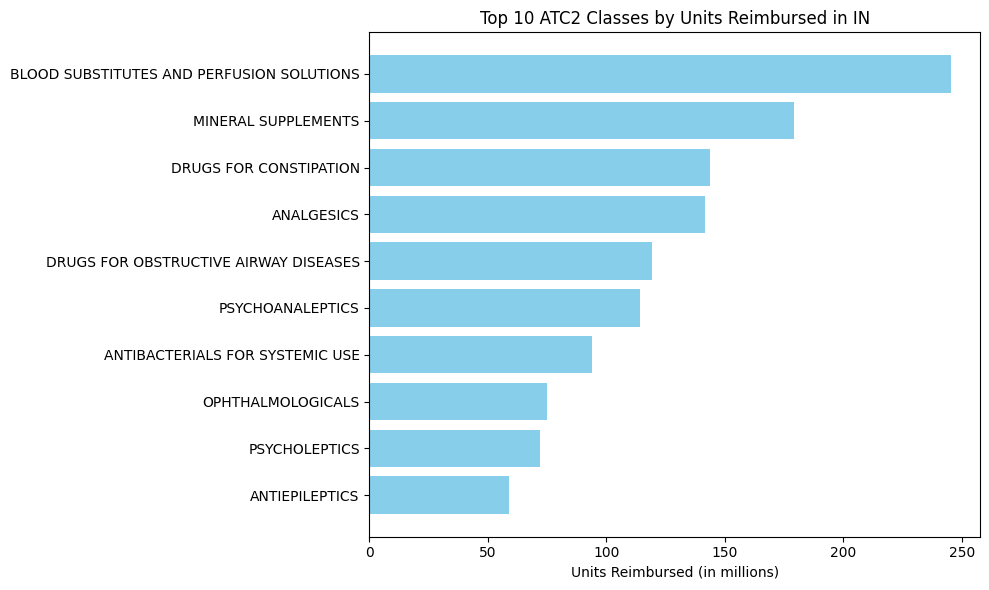

In [24]:
#Function to create a plot for top ATC2 classes by Units Reimbursed for a given state
import matplotlib.pyplot as plt
def plot_top_atc2_by_state(state_code, top_n=10):
    state_data = final_merged[final_merged['State'] == state_code]
    state_agg = state_data.groupby(['ATC2 Class', 'ATC2_Name']).agg({
        'Units Reimbursed': 'sum',
        'Number of Prescriptions': 'sum'
    }).reset_index()
    state_agg_sorted = state_agg.sort_values('Units Reimbursed', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    plt.barh(state_agg_sorted['ATC2_Name'], state_agg_sorted['Units Reimbursed'], color='skyblue')
    plt.xlabel('Units Reimbursed (in millions)')
    plt.title(f'Top {top_n} ATC2 Classes by Units Reimbursed in {state_code}')
    plt.gca().invert_yaxis()  # Highest values on top
    plt.tight_layout()
    plt.show()
#Example plot for Indiana
plot_top_atc2_by_state('IN', top_n=10)